In [1]:
import pandas as pd
import numpy as np

#import torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams


import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler



from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model
from tensorflow import keras
import tensorflow as tf

## Importing Data

In [2]:
df = pd.read_csv('day1_dataset_10min.csv')

In [3]:
df= df.drop(['Unnamed: 0'], axis=1)

In [4]:
columns = ['Datetime_updated_seconds','Price_USD','Price_Crypto','volume','densities', 'vertex_count','edge_count','collection']
X = df[columns]
y = df[['blacklisted','collection']]

In [5]:
X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']

<ipython-input-5-9f85dd7b1ed4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']


In [7]:
(X.collection.value_counts() == 144).sum()

995

In [8]:
daily_sequence = []
feature_columns=['Price_USD','Price_Crypto','volume',
                 'densities', 'vertex_count','edge_count', 'collection', 'vertext_edge_ratio']
print(feature_columns)
for collection, group in X.groupby("collection"):
    features = group[group.columns.intersection(feature_columns)]
    blacklist = y[y.collection == collection].iloc[0].blacklisted
    daily_sequence.append((features, collection, blacklist))

['Price_USD', 'Price_Crypto', 'volume', 'densities', 'vertex_count', 'edge_count', 'collection', 'vertext_edge_ratio']


In [9]:
train_sequences, test_sequences = train_test_split(daily_sequence, test_size = 0.3)

In [10]:
len(train_sequences), len(test_sequences)

(696, 299)

In [11]:
def scale_dataset(sequences, columns = ['Price_USD', 'Price_Crypto', 'volume', 'densities', 'vertex_count', 
                              'edge_count','vertext_edge_ratio'], fitted_scaler = None):
    collection_blacklist_dict = {sequence[1]:sequence[2] for sequence in sequences}
    concat_df = pd.concat([sequence[0] for sequence in sequences])
    if fitted_scaler is None:
        fitted_scaler = StandardScaler()
        fitted_scaler.fit(concat_df[columns])
    concat_df[columns] = fitted_scaler.transform(concat_df[columns])
    return  [(group[columns], collection_blacklist_dict[collection]) 
             for collection, group in concat_df.groupby("collection")] , fitted_scaler

In [12]:
scaled_train_sequences, scaler = scale_dataset(train_sequences)

In [13]:
scaled_test_sequences ,  _ = scale_dataset(test_sequences, fitted_scaler= scaler)

In [15]:
scaled_test_sequences[182]

(       Price_USD  Price_Crypto    volume  densities  vertex_count  edge_count  \
 90144   1.421989      0.747389  0.305937   1.053388       -0.1707   -0.159804   
 90145   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 90146   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 90147   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 90148   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 ...          ...           ...       ...        ...           ...         ...   
 90283   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 90284   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 90285   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 90286   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 90287   1.421989      0.747389 -0.063132   1.053388       -0.1707   -0.159804   
 
        vertex

## Model

In [16]:
NUM_FILTERS = 10
K_SIZE = 4
MODEL_SHAPE = scaled_train_sequences[0][0].shape

In [17]:
MODEL_SHAPE

(144, 7)

In [18]:
def get_base_model(shape, k_size = K_SIZE, num_filters = NUM_FILTERS):
    print(shape)
    input_seq = Input(shape=shape)
    nb_filters = num_filters
    convolved = Conv1D(num_filters, k_size, padding="same", activation="relu")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    compressed = Dense(50, activation="relu")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model

In [19]:
def main_model(shape):
    print(shape)
    input_origseq = Input(shape=shape)
    base_model = get_base_model(shape)
    out = Dense(1, activation='sigmoid')(base_model.output)
    model = Model(inputs=base_model.input, outputs=out)
    return model

In [20]:
def run_model(x_train, y_train, x_test, y_test):
    es = keras.callbacks.EarlyStopping(min_delta=0.00001, patience=10)
    #data_set = tf.data.Dataset.from_tensor_slices(  (x_train ,y_train) )
    model = main_model(MODEL_SHAPE)
    model.compile(loss='binary_crossentropy', # categorical_crossentropy
                          optimizer='adam', #sgd, nadam, adam, rmsprop
                          metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                                   tf.keras.metrics.AUC(curve='PR')])
    model_hist = model.fit(x_train, y_train,
                               validation_data=(x_test, y_test),
                               batch_size=100, epochs=1000, 
                           callbacks=[es]
                          )
    return model_hist, model

In [21]:
X_train = [sequence[0].to_numpy() for sequence in scaled_train_sequences]
y_train = [sequence[1] for sequence in scaled_train_sequences]
X_test = [sequence[0].to_numpy() for sequence in scaled_test_sequences]
y_test = [sequence[1] for sequence in scaled_test_sequences]

In [22]:
X_test = np.stack(X_test)

In [23]:
X_train = np.stack(X_train)

In [24]:
X_train = X_train.reshape(696,144,7)
y_train =   np.array(y_train)

In [25]:
X_test = X_test.reshape(299,144,7)
y_test =  np.array(y_test)

In [26]:
model_hist, model = run_model(X_train, y_train, X_test,  y_test)

(144, 7)
(144, 7)
Epoch 1/1000
7/7 [==============================] - 2s 79ms/step - loss: 0.8459 - binary_accuracy: 0.3276 - precision: 0.2923 - recall: 0.9024 - auc: 0.2483 - val_loss: 0.8501 - val_binary_accuracy: 0.2609 - val_precision: 0.2294 - val_recall: 0.9143 - val_auc: 0.1874
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.7286 - binary_accuracy: 0.4353 - precision: 0.3127 - recall: 0.7659 - auc: 0.3090 - val_loss: 0.7425 - val_binary_accuracy: 0.4281 - val_precision: 0.2328 - val_recall: 0.6286 - val_auc: 0.2044
Epoch 3/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.6876 - binary_accuracy: 0.5187 - precision: 0.2711 - recall: 0.3756 - auc: 0.2776 - val_loss: 0.6569 - val_binary_accuracy: 0.7559 - val_precision: 0.2000 - val_recall: 0.0143 - val_auc: 0.2465
Epoch 4/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.6612 - binary_accuracy: 0.6523 - precision: 0.2771 - recall: 0.1122 - auc: 0.2863 - val_loss: 0.6056 - 

7/7 [==============================] - 0s 12ms/step - loss: 0.5745 - binary_accuracy: 0.7055 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3794 - val_loss: 0.5101 - val_binary_accuracy: 0.7659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3720
Epoch 31/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.5777 - binary_accuracy: 0.7055 - precision: 0.5000 - recall: 0.0049 - auc: 0.3889 - val_loss: 0.5099 - val_binary_accuracy: 0.7659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3696
Epoch 32/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.5693 - binary_accuracy: 0.7055 - precision: 0.5000 - recall: 0.0049 - auc: 0.3912 - val_loss: 0.5097 - val_binary_accuracy: 0.7659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3698
Epoch 33/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.5680 - binary_accuracy: 0.7069 - precision: 1.0000 - recall: 0.0049 - auc: 0.4090 - val_loss: 0.5

Epoch 60/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.5535 - binary_accuracy: 0.7112 - precision: 0.7000 - recall: 0.0341 - auc: 0.4487 - val_loss: 0.5009 - val_binary_accuracy: 0.7726 - val_precision: 1.0000 - val_recall: 0.0286 - val_auc: 0.3900
Epoch 61/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.5599 - binary_accuracy: 0.7069 - precision: 0.5333 - recall: 0.0390 - auc: 0.4327 - val_loss: 0.5015 - val_binary_accuracy: 0.7726 - val_precision: 1.0000 - val_recall: 0.0286 - val_auc: 0.3892
Epoch 62/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.5582 - binary_accuracy: 0.7126 - precision: 0.8571 - recall: 0.0293 - auc: 0.4502 - val_loss: 0.5021 - val_binary_accuracy: 0.7726 - val_precision: 1.0000 - val_recall: 0.0286 - val_auc: 0.3852
Epoch 63/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.5631 - binary_accuracy: 0.7083 - precision: 0.6000 - recall: 0.0293 - auc: 0.4383 - val_loss: 0.5025 - val_binary_accu

7/7 [==============================] - 0s 8ms/step - loss: 0.5472 - binary_accuracy: 0.7213 - precision: 0.7200 - recall: 0.0878 - auc: 0.4814 - val_loss: 0.4960 - val_binary_accuracy: 0.7625 - val_precision: 0.4286 - val_recall: 0.0429 - val_auc: 0.4094
Epoch 91/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.5451 - binary_accuracy: 0.7227 - precision: 0.7143 - recall: 0.0976 - auc: 0.5023 - val_loss: 0.4957 - val_binary_accuracy: 0.7525 - val_precision: 0.3333 - val_recall: 0.0571 - val_auc: 0.4064
Epoch 92/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.5488 - binary_accuracy: 0.7184 - precision: 0.6452 - recall: 0.0976 - auc: 0.4807 - val_loss: 0.4949 - val_binary_accuracy: 0.7525 - val_precision: 0.3333 - val_recall: 0.0571 - val_auc: 0.4094
Epoch 93/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.5361 - binary_accuracy: 0.7256 - precision: 0.7059 - recall: 0.1171 - auc: 0.5015 - val_loss: 0.4945 - val_binary_accuracy: 0.7458 -

7/7 [==============================] - 0s 9ms/step - loss: 0.5257 - binary_accuracy: 0.7399 - precision: 0.7222 - recall: 0.1902 - auc: 0.5481 - val_loss: 0.4896 - val_binary_accuracy: 0.7559 - val_precision: 0.4348 - val_recall: 0.1429 - val_auc: 0.4254
Epoch 121/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.5342 - binary_accuracy: 0.7313 - precision: 0.6957 - recall: 0.1561 - auc: 0.5114 - val_loss: 0.4907 - val_binary_accuracy: 0.7592 - val_precision: 0.4583 - val_recall: 0.1571 - val_auc: 0.4281
Epoch 122/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.5246 - binary_accuracy: 0.7399 - precision: 0.7222 - recall: 0.1902 - auc: 0.5377 - val_loss: 0.4907 - val_binary_accuracy: 0.7592 - val_precision: 0.4583 - val_recall: 0.1571 - val_auc: 0.4268
Epoch 123/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.5304 - binary_accuracy: 0.7414 - precision: 0.7049 - recall: 0.2098 - auc: 0.5315 - val_loss: 0.4912 - val_binary_accuracy: 0.759

In [ ]:
prediction = model.predict(all_x_test)

In [ ]:
prediction[prediction <=0.5] = 0
prediction[prediction >0.5] = 1

In [ ]:
[pred[0] for pred in prediction.tolist()]

In [27]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_binary_accuracy'] + history.history['binary_accuracy']),
                        max(history.history['val_binary_accuracy'] + history.history['binary_accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['binary_accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['binary_accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_binary_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [31]:
def plot_training_curves_auc(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_auc'] + history.history['auc']),
                        max(history.history['val_auc'] + history.history['auc']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['auc']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['auc'], label = 'auc')
    ax[1].plot(index, history.history['val_auc'], label = 'val_auc')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('AUC')
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

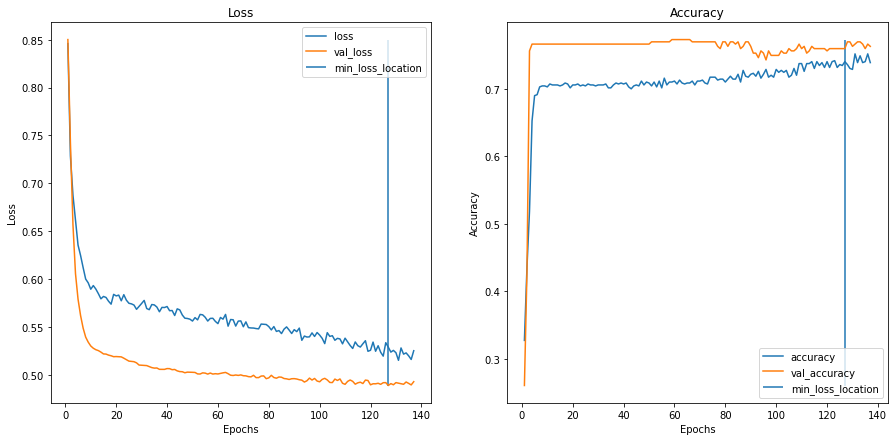

In [28]:
plot_training_curves(history=model_hist)

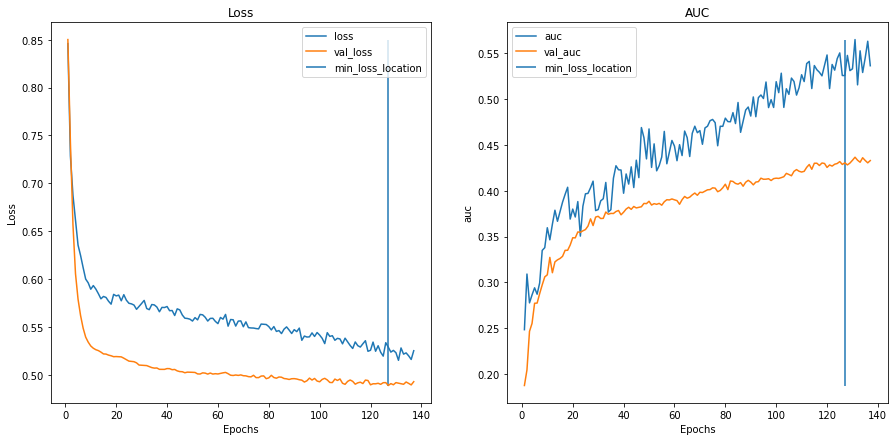

In [32]:
plot_training_curves_auc(history=model_hist)